<center><h1> Exploratory Data Analysis of car dataseet </h1></center>
***

In this notebook, I will explore and analyze my data, visuliaze connections between features and do some statistic manipulations to show main characteristics of data. First I will import data, that "page-scarper.py" got from [cars.kg](cars.kg) and saved in "cars_raw_data.csv". I called raw, because later I will clean the data: fill missing values, detect and maybe eliminate outliers, and maybe rescale data(standartization, normalization).

I will import pandas, which is a library for data analysis, and you can see first 5 rows and last five raws of the data.

In [1]:
import pandas as pd 
import sys
pd.set_option('float_format', '{:.3f}'.format)
sys.path.append("../src")
from car_price_prediction.utils import dataset_manager

car_data = dataset_manager.get_raw_dataset()
car_data.head(5)

,Год выпуска,КПП,Марка,Мощность,Объём,Привод,Пробег,Руль,Тип кузова,Топливо,Цвет,Цена
0,2004.000,автомат,mercedes-benz,177.000,2.700,задний,,NaN,универсал,дизель,NaN,8000
1,2002.000,автомат,bmw,184.000,2.900,постоянный полный,,левый,кроссовер,дизель,серебряный,8000
2,2001.000,автомат,lexus,nan,200.000,задний,,правый,седан,бензин,мокрый асфальт,4200
3,2003.000,автомат,subaru,150.000,2.000,постоянный полный,,правый,седан,бензин,серый,3800
4,2000.000,автомат,honda,213.000,3.000,постоянный полный,10000,правый,минивэн / бус,бензин,серебряный,3300


In [2]:
car_data.tail(5)

,Год выпуска,КПП,Марка,Мощность,Объём,Привод,Пробег,Руль,Тип кузова,Топливо,Цвет,Цена
13854,2003.000,автомат,honda,nan,2.000,NaN,130000,правый,седан,бензин,серый,6200
13855,2001.000,автомат,subaru,156.000,2.500,постоянный полный,,правый,универсал,бензин,белый,2900
13856,2003.000,автомат,mazda,150.000,2.000,передний,214500,правый,хэтчбек,бензин,серый,4500
13857,2003.000,автомат,toyota,109.000,1.500,передний,126000,правый,минивэн / бус,бензин,бирюзовый,4800
13858,2002.000,автомат,nissan,170.000,3.300,полный подключаемый,338000,правый,внедорожник / пикап,бензин,серебряный,8800


The very first thing I do, is check the shape of our dataframe.

In [3]:
car_data.shape

(13859, 12)

Next we can see the quantity of missing values in each of the columns. We can see that some of the features have a lot of missing values, and some not so much. I will go three ways, first I will create a model with a dataset where all the NaN values were dropped, and second I will impute all the missing NaN values and the third I will try to make maximum unbiased dataset, managing the data as a field expert. All of the three datasets will have different level of bias, I will explore it in 'Choosing-Dataset' notebook.


In [4]:
car_data.isnull().sum()

Год выпуска     196
КПП             303
Марка             0
Мощность       2856
Объём           465
Привод         1061
Пробег            0
Руль            724
Тип кузова       48
Топливо         294
Цвет           1094
Цена              0
dtype: int64

Next I would like to see detailed statistical summary of data. From the summary, we can see that mean of data and standard deviation have extreme values, and looking at max values at dataset, I can suggest that maximum values skewed the mean and std methods, later I will eliminate or impute those extreme values in dataset, also in next summary we can see the datatype of each column that we have.

In [5]:
car_data.describe()

,Год выпуска,Мощность,Объём,Цена
count,13663.000,11003.000,13394.000,13859.000
mean,2005.571,1009826414136.189,62662.992,74037.542
std,7.040,105925844237632.312,6149506.768,6568532.368
min,1961.000,1.000,-2.500,0.000
25%,2002.000,135.000,2.000,4000.000
50%,2005.000,173.000,2.400,8300.000
75%,2012.000,249.000,3.200,18676.500
max,2018.000,11111111111111110.000,705435466.000,773152600.000


In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13859 entries, 0 to 13858
Data columns (total 12 columns):
Год выпуска    13663 non-null float64
КПП            13556 non-null object
Марка          13859 non-null object
Мощность       11003 non-null float64
Объём          13394 non-null float64
Привод         12798 non-null object
Пробег         13859 non-null object
Руль           13135 non-null object
Тип кузова     13811 non-null object
Топливо        13565 non-null object
Цвет           12765 non-null object
Цена           13859 non-null int64
dtypes: float64(3), int64(1), object(8)
memory usage: 866.2+ KB


Next, I would want to see the correlation matrix between each of the continous(numeric) features.  
By looking at summary above, I now know that dataset has extreme values in the data, each one of continious variables contains extreme values, which we need to eliminate, or make it NaN and impute, because if we won't, it will make a huge affect on correlations and predictions.  
In the plot below we can see that correlation between continous variables is very low, it is due to the skewed data. There is no meaining at keeping analysis with this kind of data, at first I will eliminate extreme values just to see important relationships, I will not change dataset, the dataset will be changed and cleaned in "Data-Cleaning" notebook. I will clean data by "cleaning-outliers.py" script, by eliminating meaningless data, like: impossible mileage, capacity or engine power.

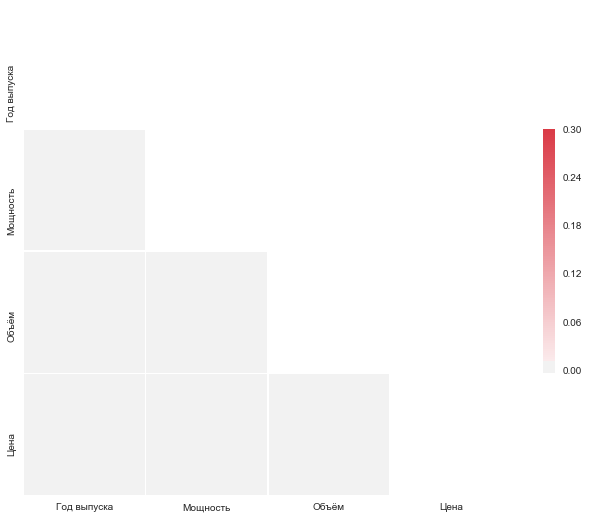

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

def plot_heatmap(data):
    sns.set(style = "white")
    corr = data.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
plot_heatmap(car_data)

In the dataset categorical features don't have extreme values, and continuous feature "Год выпуска" doesn't have extreme values too. I think it is due to the way people could post advertisements. Categorical features and year feature could be inputed via selection, and continous numbers could be of any range.

In [8]:
car_data.isnull().sum()

Год выпуска     196
КПП             303
Марка             0
Мощность       2856
Объём           465
Привод         1061
Пробег            0
Руль            724
Тип кузова       48
Топливо         294
Цвет           1094
Цена              0
dtype: int64

Now I will download data cleaned from outliers and impossible values, and we can see that number of NaN values increased, I made some extreme values NaN, so later i could impute that data. After, I will drop some non-needed values.

In [9]:
car_data = dataset_manager.get_cleaned_outliers_dataset()
car_data.isnull().sum()

Год выпуска     185
КПП             287
Марка             0
Мощность       2961
Объём           772
Привод         1015
Пробег         5187
Руль            693
Тип кузова       48
Топливо         277
Цвет           1047
Цена              0
dtype: int64

Now we can continue our Exploritary Analysis. And right away we can see, that all statistic summary now makes full sense. And correlation plotting now is a little bit more reassuring.

In [10]:
car_data.describe()

,Год выпуска,Мощность,Объём,Пробег,Цена
count,13387.000,10611.000,12800.000,8385.000,13572.000
mean,2005.733,196.722,2.651,129075.606,14943.743
std,6.908,86.915,1.091,83745.988,18996.475
min,1961.000,51.000,0.700,1.000,520.000
25%,2002.000,136.000,2.000,71500.000,4100.000
50%,2005.000,173.000,2.400,123456.000,8200.000
75%,2012.000,249.000,3.000,179382.000,18267.250
max,2018.000,585.000,6.300,800000.000,284000.000


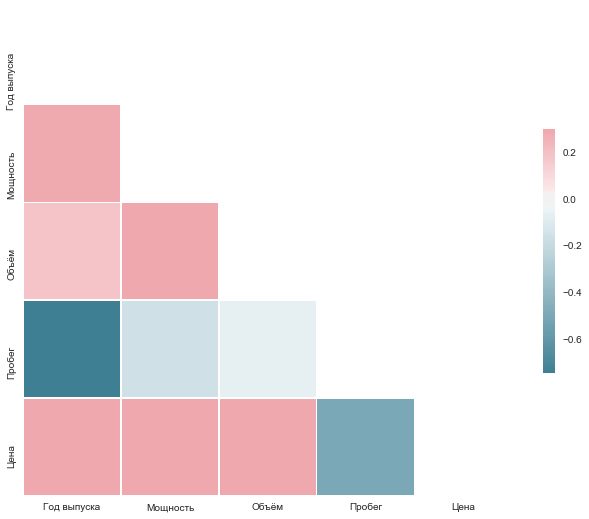

In [11]:
plot_heatmap(car_data)

In [12]:
car_data.corr()

,Год выпуска,Мощность,Объём,Пробег,Цена
Год выпуска,1.000,0.289,0.184,-0.751,0.612
Мощность,0.289,1.000,0.875,-0.156,0.580
Объём,0.184,0.875,1.000,-0.064,0.491
Пробег,-0.751,-0.156,-0.064,1.000,-0.503
Цена,0.612,0.580,0.491,-0.503,1.000


Now it's time to see, which features of dataset are important and which are not so. I am going to use RandomForest Regressor module from scklearn library to analyze importance of features. Also, I wll use OneHotEncoder to make categorical features numeric.  
I will drop the NaN values for this example, because RandomForestRegressor doesn't take as an input data with missing values.
I will replace NaN values in urgency column, cause there is a lot of missing values there.  
And also I will drop power column, because of several reasons:
* Power column is dependent from capacity column on 87.5 per cent, we can see it above in correlation matrix
* Most of the people in KG doesn't care about the power, but do about capacity, that's why there are a lot of NaN values in power column, and a lot of impossible values
* Later in notebooks, we will see that power column actually deteriorate prediction accuracy

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from car_price_prediction.utils import df_utils

car_data.dropna(inplace=True)
car_data.drop(columns = ["Мощность"], inplace = True)

In [14]:
X,y = df_utils.get_data_and_target(car_data)
X_dummies = pd.get_dummies(X)
forest = RandomForestRegressor()
feat_labels = X_dummies.columns[:-1]
forest.fit(X_dummies,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
    
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), X_dummies.columns.values), reverse=True))

Features sorted by their score:
[(0.417, 'Год выпуска'), (0.3612, 'Объём'), (0.0835, 'Пробег'), (0.0236, 'Марка_porsche'), (0.0163, 'КПП_типтроник'), (0.0115, 'Марка_mercedes-benz'), (0.0093, 'Тип кузова_кроссовер'), (0.0083, 'Марка_lexus'), (0.0049, 'Тип кузова_седан'), (0.0049, 'Марка_cadillac'), (0.0048, 'Тип кузова_минивэн / бус'), (0.0044, 'Тип кузова_хэтчбек'), (0.0038, 'Тип кузова_внедорожник / пикап'), (0.0036, 'Привод_постоянный полный'), (0.0032, 'Топливо_дизель'), (0.0027, 'Цвет_черный'), (0.0027, 'КПП_механика'), (0.0025, 'Марка_bmw'), (0.0024, 'Марка_уаз'), (0.0023, 'Марка_toyota'), (0.002, 'Топливо_бензин'), (0.002, 'Тип кузова_кабриолет'), (0.0019, 'Тип кузова_купе'), (0.0017, 'Марка_land rover'), (0.0015, 'Цвет_белый'), (0.0013, 'Цвет_серый'), (0.0013, 'Привод_передний'), (0.0012, 'КПП_вариатор'), (0.0011, 'Марка_ford'), (0.001, 'Марка_hyundai'), (0.001, 'Марка_audi'), (0.0009, 'Топливо_газ-бензин'), (0.0008, 'Марка_infiniti'), (0.0007, 'Цвет_коричневый'), (0.0007, 'Мар

Now we will make use of dimensionality reduction algorithm which is called Principal Component Analysis(PCA). It will allow us to reduce the number of dimensions of a dataset. To visualize data I will reduce the number of dimensions to two. At first we will scale the whole dataset so it will have near to equal sizes. We will scale dataset via StandartScaler module of scikit learn module.From this plot we can see the distribution of data, and outliers as well.

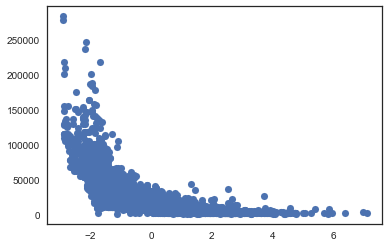

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=1)
scaler = StandardScaler()
X_scaled = df_utils.scale_train(X)
X_pca = pd.get_dummies(X_scaled)
X_pca = pca.fit_transform(X_pca)
plt.scatter(X_pca,y,marker = "o",lw=0.1)

In [16]:
car_data.rank().corr('spearman')

,Год выпуска,КПП,Марка,Объём,Привод,Пробег,Руль,Тип кузова,Топливо,Цвет,Цена
Год выпуска,1.000,0.003,-0.002,0.061,0.252,-0.819,-0.455,-0.246,0.052,0.034,0.784
КПП,0.003,1.000,0.142,-0.444,-0.186,-0.029,-0.127,0.198,-0.064,-0.045,-0.253
Марка,-0.002,0.142,1.000,-0.066,-0.044,-0.016,0.058,0.010,-0.097,-0.037,-0.085
Объём,0.061,-0.444,-0.066,1.000,0.437,0.011,-0.180,-0.534,0.089,0.126,0.529
Привод,0.252,-0.186,-0.044,0.437,1.000,-0.164,-0.122,-0.604,0.182,0.071,0.497
Пробег,-0.819,-0.029,-0.016,0.011,-0.164,1.000,0.326,0.152,0.044,0.018,-0.631
Руль,-0.455,-0.127,0.058,-0.180,-0.122,0.326,1.000,0.217,-0.085,-0.099,-0.469
Тип кузова,-0.246,0.198,0.010,-0.534,-0.604,0.152,0.217,1.000,-0.234,-0.046,-0.524
Топливо,0.052,-0.064,-0.097,0.089,0.182,0.044,-0.085,-0.234,1.000,0.021,0.148
Цвет,0.034,-0.045,-0.037,0.126,0.071,0.018,-0.099,-0.046,0.021,1.000,0.090


We finished the exlporitary analysis of our data. Next thing I will do is a cleaning the data.